In [4]:
import pandas as pd
import sys
import numpy as np
import random
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.base import ClusteringScoreVisualizer
from tqdm.notebook import tqdm

In [5]:
Random = random
Random.seed(123)

In [6]:
Departamento = 'SOAD'
df = pd.read_csv("dataset_nlp_clean.csv", encoding='utf-8', keep_default_na = False, na_values=['', ' '])

df['nlp_lemma'] = df['nlp_lemma'].replace(np.NaN, '')
df['nlp_lemma'] = [str(text) for text in df['nlp_lemma']]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96122 entries, 0 to 96121
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Código del expediente         96122 non-null  int64 
 1   Número del procedimiento      96120 non-null  object
 2   Carácter del procedimiento    94081 non-null  object
 3   Forma del procedimiento       94087 non-null  object
 4   Artículo de excepción         83724 non-null  object
 5   REFERENCIA_EXPEDIENTE         92093 non-null  object
 6   Título del expediente         96122 non-null  object
 7   Plantilla del expediente      96122 non-null  object
 8   Descripción del Anuncio       96121 non-null  object
 9   Clave de la UC                96122 non-null  object
 10  Nombre de la UC               96122 non-null  object
 11  Operador                      96122 non-null  object
 12  Correo electrónico            96122 non-null  object
 13  Entidad federati

In [10]:
# df.OracionLematizada = df.OracionLematizada.fillna(' ')
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.99)
dtm = tfidf.fit_transform(df['nlp_lemma'].values)

In [11]:
dtm.shape

(96122, 199)

In [12]:
full_svd = TruncatedSVD(n_components=dtm.shape[1]-1)
X_full_svd = full_svd.fit(dtm)

full_svd_ratios = full_svd.explained_variance_ratio_

# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

# Run function
selected_n = select_n_components(full_svd_ratios, 0.95)
print(selected_n)

112


In [13]:
svd = TruncatedSVD(selected_n, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(dtm)

In [14]:
svd_ratios = svd.explained_variance_ratio_
print(sum(svd_ratios))

0.9516388454858314


Override for TQDM Visualization.

API Link: https://www.scikit-yb.org/en/latest/_modules/yellowbrick/cluster/elbow.html

In [15]:
# yellowbrick.cluster.elbow
# Implements the elbow method for determining the optimal number of clusters.
#
# Author:   Benjamin Bengfort
# Created:  Thu Mar 23 22:36:31 2017 -0400
#
# Copyright (C) 2016 The scikit-yb developers
# For license information, see LICENSE.txt
#
# ID: elbow.py [5a370c8] benjamin@bengfort.com $

"""
Implements the elbow method for determining the optimal number of clusters.
https://bl.ocks.org/rpgove/0060ff3b656618e9136b
"""

##########################################################################
## Imports
##########################################################################

import time
import warnings
import numpy as np
import scipy.sparse as sp
from collections.abc import Iterable

from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import pairwise_distances

from yellowbrick.utils import KneeLocator
from yellowbrick.style.palettes import LINE_COLOR
from yellowbrick.cluster.base import ClusteringScoreVisualizer
from yellowbrick.exceptions import YellowbrickValueError, YellowbrickWarning

try:
    from sklearn.metrics import calinski_harabasz_score as chs
except ImportError:
    from sklearn.metrics import calinski_harabaz_score as chs


## Packages for export
__all__ = ["KElbowVisualizer", "KElbow", "distortion_score", "kelbow_visualizer"]


##########################################################################
## Metrics
##########################################################################


def distortion_score(X, labels, metric="euclidean"):
    """
    Compute the mean distortion of all samples.

    The distortion is computed as the the sum of the squared distances between
    each observation and its closest centroid. Logically, this is the metric
    that K-Means attempts to minimize as it is fitting the model.

    .. seealso:: http://kldavenport.com/the-cost-function-of-k-means/

    Parameters
    ----------
    X : array, shape = [n_samples, n_features] or [n_samples_a, n_samples_a]
        Array of pairwise distances between samples if metric == "precomputed"
        or a feature array for computing distances against the labels.

    labels : array, shape = [n_samples]
        Predicted labels for each sample

    metric : string
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by `sklearn.metrics.pairwise.pairwise_distances
        <http://bit.ly/2Z7Dxnn>`_

    .. todo:: add sample_size and random_state kwds similar to silhouette_score
    """
    # Encode labels to get unique centers and groups
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    unique_labels = le.classes_

    # Sum of the distortions
    distortion = 0

    # Loop through each label (center) to compute the centroid
    for current_label in unique_labels:
        # Mask the instances that belong to the current label
        mask = labels == current_label
        instances = X[mask]

        # Compute the center of these instances
        center = instances.mean(axis=0)

        # NOTE: csc_matrix and csr_matrix mean returns a 2D array, numpy.mean
        # returns an array of 1 dimension less than the input. We expect
        # instances to be a 2D array, therefore to do pairwise computation we
        # require center to be a 2D array with a single row (the center).
        # See #370 for more detail.
        if not sp.issparse(instances):
            center = np.array([center])

        # Compute the square distances from the instances to the center
        distances = pairwise_distances(instances, center, metric=metric)
        distances = distances ** 2

        # Add the sum of square distance to the distortion
        distortion += distances.sum()

    return distortion


##########################################################################
## Elbow Method
##########################################################################

KELBOW_SCOREMAP = {
    "distortion": distortion_score,
    "silhouette": silhouette_score,
    "calinski_harabasz": chs,
}


class KElbowVisualizer(ClusteringScoreVisualizer):
    """
    The K-Elbow Visualizer implements the "elbow" method of selecting the
    optimal number of clusters for K-means clustering. K-means is a simple
    unsupervised machine learning algorithm that groups data into a specified
    number (k) of clusters. Because the user must specify in advance what k to
    choose, the algorithm is somewhat naive -- it assigns all members to k
    clusters even if that is not the right k for the dataset.

    The elbow method runs k-means clustering on the dataset for a range of
    values for k (say from 1-10) and then for each value of k computes an
    average score for all clusters. By default, the ``distortion`` score is
    computed, the sum of square distances from each point to its assigned
    center. Other metrics can also be used such as the ``silhouette`` score,
    the mean silhouette coefficient for all samples or the
    ``calinski_harabasz`` score, which computes the ratio of dispersion between
    and within clusters.

    When these overall metrics for each model are plotted, it is possible to
    visually determine the best value for k. If the line chart looks like an
    arm, then the "elbow" (the point of inflection on the curve) is the best
    value of k. The "arm" can be either up or down, but if there is a strong
    inflection point, it is a good indication that the underlying model fits
    best at that point.

    Parameters
    ----------

    model : a scikit-learn clusterer
        Should be an instance of an unfitted clusterer, specifically ``KMeans`` or
        ``MiniBatchKMeans``. If it is not a clusterer, an exception is raised.

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    k : integer, tuple, or iterable
        The k values to compute silhouette scores for. If a single integer
        is specified, then will compute the range (2,k). If a tuple of 2
        integers is specified, then k will be in np.arange(k[0], k[1]).
        Otherwise, specify an iterable of integers to use as values for k.

    metric : string, default: ``"distortion"``
        Select the scoring metric to evaluate the clusters. The default is the
        mean distortion, defined by the sum of squared distances between each
        observation and its closest centroid. Other metrics include:

        - **distortion**: mean sum of squared distances to centers
        - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
        - **calinski_harabasz**: ratio of within to between cluster dispersion

    timings : bool, default: True
        Display the fitting time per k to evaluate the amount of time required
        to train the clustering model.

    locate_elbow : bool, default: True
        Automatically find the "elbow" or "knee" which likely corresponds to the optimal
        value of k using the "knee point detection algorithm". The knee point detection
        algorithm finds the point of maximum curvature, which in a well-behaved
        clustering problem also represents the pivot of the elbow curve. The point is
        labeled with a dashed line and annotated with the score and k values.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Attributes
    ----------
    k_scores_ : array of shape (n,) where n is no. of k values
        The silhouette score corresponding to each k value.

    k_timers_ : array of shape (n,) where n is no. of k values
        The time taken to fit n KMeans model corresponding to each k value.

    elbow_value_ : integer
        The optimal value of k.

    elbow_score_ : float
        The silhouette score corresponding to the optimal value of k.

    Examples
    --------

    >>> from yellowbrick.cluster import KElbowVisualizer
    >>> from sklearn.cluster import KMeans
    >>> model = KElbowVisualizer(KMeans(), k=10)
    >>> model.fit(X)
    >>> model.show()

    Notes
    -----

    If you get a visualizer that doesn't have an elbow or inflection point,
    then this method may not be working. The elbow method does not work well
    if the data is not very clustered; in this case, you might see a smooth
    curve and the value of k is unclear. Other scoring methods, such as BIC or
    SSE, also can be used to explore if clustering is a correct choice.

    For a discussion on the Elbow method, read more at
    `Robert Gove's Block website <https://bl.ocks.org/rpgove/0060ff3b656618e9136b>`_.
    For more on the knee point detection algorithm see the paper `"Finding a "kneedle"
    in a Haystack" <https://raghavan.usc.edu//papers/kneedle-simplex11.pdf>`_.

    .. seealso:: The scikit-learn documentation for the `silhouette_score
        <https://bit.ly/2LYWjYb>`_ and `calinski_harabasz_score
        <https://bit.ly/2ItAgts>`_. The default, ``distortion_score``, is
        implemented in ``yellowbrick.cluster.elbow``.

    .. todo:: add parallelization option for performance
    .. todo:: add different metrics for scores and silhouette
    .. todo:: add timing information about how long it's taking
    """

    def __init__(
        self,
        model,
        ax=None,
        k=10,
        metric="distortion",
        timings=True,
        locate_elbow=True,
        **kwargs
    ):
        super(KElbowVisualizer, self).__init__(model, ax=ax, **kwargs)

        # Get the scoring method
        if metric not in KELBOW_SCOREMAP:
            raise YellowbrickValueError(
                "'{}' is not a defined metric "
                "use one of distortion, silhouette, or calinski_harabasz"
            )

        # Store the arguments
        self.scoring_metric = KELBOW_SCOREMAP[metric]
        self.metric = metric
        self.timings = timings
        self.locate_elbow = locate_elbow

        # Convert K into a tuple argument if an integer
        if isinstance(k, int):
            self.k_values_ = list(range(2, k + 1))
        elif (
            isinstance(k, tuple)
            and len(k) == 2
            and all(isinstance(x, (int, np.integer)) for x in k)
        ):
            self.k_values_ = list(range(*k))
        elif isinstance(k, Iterable) and all(
            isinstance(x, (int, np.integer)) for x in k
        ):
            self.k_values_ = list(k)
        else:
            raise YellowbrickValueError(
                (
                    "Specify an iterable of integers, a range, or maximal K value,"
                    " the value '{}' is not a valid argument for K.".format(k)
                )
            )

        # Holds the values of the silhoutte scores
        self.k_scores_ = None
        # Set Default Elbow Value
        self.elbow_value_ = None

    def fit(self, X, y=None, **kwargs):
        """
        Fits n KMeans models where n is the length of ``self.k_values_``,
        storing the silhouette scores in the ``self.k_scores_`` attribute.
        The "elbow" and silhouette score corresponding to it are stored in
        ``self.elbow_value`` and ``self.elbow_score`` respectively.
        This method finishes up by calling draw to create the plot.
        """

        self.k_scores_ = []
        self.k_timers_ = []
        self.kneedle = None
        self.knee_value = None

        if self.locate_elbow:
            self.elbow_value_ = None
            self.elbow_score_ = None

        with tqdm(total = len(self.k_values_), bar_format='{bar}|{desc}{percentage:3.0f}% {r_bar}') as pbar:
            pbar.set_description(f"KElbowVisualizer...")
            for k in self.k_values_:
                # Compute the start time for each  model
                start = time.time()

                # Set the k value and fit the model
                self.estimator.set_params(n_clusters=k)
                self.estimator.fit(X)

                # Append the time and score to our plottable metrics
                self.k_timers_.append(time.time() - start)
                self.k_scores_.append(self.scoring_metric(X, self.estimator.labels_))
                pbar.update(1)

        if self.locate_elbow:
            locator_kwargs = {
                "distortion": {
                    "curve_nature": "convex",
                    "curve_direction": "decreasing",
                },
                "silhouette": {
                    "curve_nature": "concave",
                    "curve_direction": "increasing",
                },
                "calinski_harabasz": {
                    "curve_nature": "concave",
                    "curve_direction": "increasing",
                },
            }.get(self.metric, {})
            elbow_locator = KneeLocator(
                self.k_values_, self.k_scores_, **locator_kwargs
            )
            if elbow_locator.knee is None:
                self.elbow_value_ = None
                self.elbow_score_ = 0
                warning_message = (
                    "No 'knee' or 'elbow' point detected, "
                    "pass `locate_elbow=False` to remove the warning"
                )
                warnings.warn(warning_message, YellowbrickWarning)
            else:
                self.elbow_value_ = elbow_locator.knee
                self.elbow_score_ = self.k_scores_[
                    self.k_values_.index(self.elbow_value_)
                ]

        self.draw()

        return self


    def draw(self):
        """
        Draw the elbow curve for the specified scores and values of K.
        """
        # Plot the silhouette score against k
        self.ax.plot(self.k_values_, self.k_scores_, marker="D")
        if self.locate_elbow is True and self.elbow_value_ is not None:
            elbow_label = "$elbow at k={}, score={:0.3f}$".format(
                self.elbow_value_, self.elbow_score_
            )
            self.ax.axvline(
                self.elbow_value_, c=LINE_COLOR, linestyle="--", label=elbow_label
            )

        # If we're going to plot the timings, create a twinx axis
        if self.timings:
            self.axes = [self.ax, self.ax.twinx()]
            self.axes[1].plot(
                self.k_values_,
                self.k_timers_,
                label="fit time",
                c="g",
                marker="o",
                linestyle="--",
                alpha=0.75,
            )

        return self.ax


    def finalize(self):
        """
        Prepare the figure for rendering by setting the title as well as the
        X and Y axis labels and adding the legend.

        """
        # Get the metric name
        metric = self.scoring_metric.__name__.replace("_", " ").title()

        # Set the title
        self.set_title("{} Elbow for {} Clustering".format(metric, self.name))

        # Set the x and y labels
        self.ax.set_xlabel("k")
        self.ax.set_ylabel(metric.lower())

        # set the legend if locate_elbow=True
        if self.locate_elbow is True and self.elbow_value_ is not None:
            self.ax.legend(loc="best", fontsize="medium")

        # Set the second y axis labels
        if self.timings:
            self.axes[1].grid(False)
            self.axes[1].set_ylabel("fit time (seconds)", color="g")
            self.axes[1].tick_params("y", colors="g")



# alias
KElbow = KElbowVisualizer


##########################################################################
## Quick Method
##########################################################################

def kelbow_visualizer(
    model,
    X,
    y=None,
    ax=None,
    k=10,
    metric="distortion",
    timings=True,
    locate_elbow=True,
    show=True,
    **kwargs
):
    """
    Quick Method:

    model : a Scikit-Learn clusterer
        Should be an instance of an unfitted clusterer, specifically
        ``KMeans`` or ``MiniBatchKMeans``. If it is not a clusterer, an
        exception is raised.

    X : array-like of shape (n, m)
        A matrix or data frame with n instances and m features

    y : array-like of shape (n,), optional
        A vector or series representing the target for each instance

    ax : matplotlib Axes, default: None
        The axes to plot the figure on. If None is passed in the current axes
        will be used (or generated if required).

    k : integer, tuple, or iterable
        The k values to compute silhouette scores for. If a single integer
        is specified, then will compute the range (2,k). If a tuple of 2
        integers is specified, then k will be in np.arange(k[0], k[1]).
        Otherwise, specify an iterable of integers to use as values for k.

    metric : string, default: ``"distortion"``
        Select the scoring metric to evaluate the clusters. The default is the
        mean distortion, defined by the sum of squared distances between each
        observation and its closest centroid. Other metrics include:

        - **distortion**: mean sum of squared distances to centers
        - **silhouette**: mean ratio of intra-cluster and nearest-cluster
                          distance
        - **calinski_harabasz**: ratio of within to between cluster dispersion

    timings : bool, default: True
        Display the fitting time per k to evaluate the amount of time required
        to train the clustering model.

    locate_elbow : bool, default: True
        Automatically find the "elbow" or "knee" which likely corresponds to
        the optimal value of k using the "knee point detection algorithm". The
        knee point detection algorithm finds the point of maximum curvature,
        which in a well-behaved clustering problem also represents the pivot
        of the elbow curve. The point is labeled with a dashed line and
        annotated with the score and k values.

    show : bool, default: True
        If True, calls ``show()``, which in turn calls ``plt.show()`` however
        you cannot call ``plt.savefig`` from this signature, nor
        ``clear_figure``. If False, simply calls ``finalize()``

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Returns
    -------
    viz : KElbowVisualizer
        The kelbow visualizer, fitted and finalized.
    """
    oz = KElbow(
        model,
        ax=ax,
        k=k,
        metric=metric,
        timings=timings,
        locate_elbow=locate_elbow,
        **kwargs
    )
    oz.fit(X, y)

    if show:
        oz.show()
    else:
        oz.finalize()

    return oz

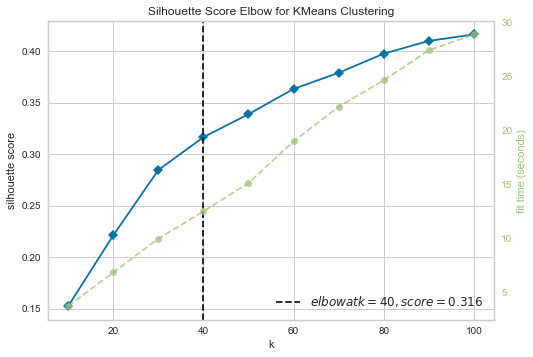

Wall time: 21min 9s


<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [19]:
%%time
visualizer = KElbowVisualizer(KMeans(random_state=0), metric='silhouette', k=range(10, 110, 10))

visualizer.fit(X)
visualizer.show()

In [26]:
model = KMeans(n_clusters=40, random_state=0)
model.fit(X)
labels = model.labels_
df['cluster_descripcion'] = labels

In [28]:
df = df[['Descripción del Anuncio', 'nlp_lemma', 'cluster_descripcion']]

df.to_csv("dataset_clusters.csv", index=False)